In [28]:
import pandas as pd
import numpy as np
from utils.hts_eda_utils import get_zero_columns, remove_zero_columns
from utils import hts_eda_utils

from matplotlib import pyplot as plt

In [2]:
original_df = pd.read_excel('data/Quarterly_smoothing.xlsx', index_col=0)

original_df = remove_zero_columns(original_df)

Removing 30 columns with all zeros


## Let's Try MA, AR and ARIMA models separately, compare performance

In [3]:
df = original_df.copy()

# Set period type to Month Start (MS)
df.index = pd.date_range(start='2018-03-01', periods=len(df), freq='MS')  # Month start


In [4]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_arima_model(order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

In [5]:
def evaluate_series(series):
    train_size = int(len(series) * 0.7)
    train, test = series[:train_size], data[train_size:]


    print('Auto Regressive')
    mse_ar, mae_ar, rmse_ar = evaluate_arima_model((1, 0, 0))
    print('AR MSE:', mse_ar, '|', 'AR MAE:', mae_ar, '|', 'AR RMSE:', rmse_ar)

    print('Moving Average')
    mse_ma, mae_ma, rmse_ma = evaluate_arima_model((0, 0, 1))
    print('MSE:', mse_ma, '|', 'MAE:', mae_ma, '|', 'RMSE:', rmse_ma)

    print('Auto Regressive Integrated Moving Average')
    mse_arima, mae_arima, rmse_arima = evaluate_arima_model((1, 0, 1))
    print('ARIMA MSE:', mse_arima, '|', 'ARIMA MAE:', mae_arima, '|', 'ARIMA RMSE:', rmse_arima)

    return {
        'AR': {'MSE': mse_ar, 'MAE': mae_ar, 'RMSE': rmse_ar},
        'MA': {'MSE': mse_ma, 'MAE': mae_ma, 'RMSE': rmse_ma},
        'ARIMA': {'MSE': mse_arima, 'MAE': mae_arima, 'RMSE': rmse_arima}
    }


In [19]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_arima_model(order, train, test):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    smape = symmetric_mean_absolute_percentage_error(test, predictions)
    return mae, rmse, mape, smape

def evaluate_series(series):
    train_size = int(len(series) * 0.7)
    train, test = series[:train_size], series[train_size:]

    # print('Auto Regressive')
    mae_ar, rmse_ar, mape_ar, smape_ar = evaluate_arima_model((1, 0, 0), train, test)
    # print('AR MAE:', mae_ar, '|', 'AR RMSE:', rmse_ar, '|', 'AR MAPE:', mape_ar, '|', 'AR SMAPE:', smape_ar)

    # print('Moving Average')
    mae_ma, rmse_ma, mape_ma, smape_ma = evaluate_arima_model((0, 0, 1), train, test)
    # print('MA MAE:', mae_ma, '|', 'MA RMSE:', rmse_ma, '|', 'MA MAPE:', mape_ma, '|', 'MA SMAPE:', smape_ma)

    # print('Auto Regressive Integrated Moving Average')
    mae_arima, rmse_arima, mape_arima, smape_arima = evaluate_arima_model((1, 0, 1), train, test)
    # print('ARIMA MAE:', mae_arima, '|', 'ARIMA RMSE:', rmse_arima, '|', 'ARIMA MAPE:', mape_arima, '|', 'ARIMA SMAPE:', smape_arima)

    return {
        'AR': {'MAE': mae_ar, 'RMSE': rmse_ar, 'MAPE': mape_ar, 'SMAPE': smape_ar},
        'MA': {'MAE': mae_ma, 'RMSE': rmse_ma, 'MAPE': mape_ma, 'SMAPE': smape_ma},
        'ARIMA': {'MAE': mae_arima, 'RMSE': rmse_arima, 'MAPE': mape_arima, 'SMAPE': smape_arima}
    }


In [20]:
evaluate_series(df.iloc[:,0]) # This is a bad example cuz all sales go to 0 in the last 6 mo

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'AR': {'MAE': 990.4492721364645,
  'RMSE': 1019.4562565642592,
  'MAPE': inf,
  'SMAPE': 200.0},
 'MA': {'MAE': 1144.0659262527527,
  'RMSE': 1148.8763467482672,
  'MAPE': inf,
  'SMAPE': 200.0},
 'ARIMA': {'MAE': 1051.3554520795733,
  'RMSE': 1074.7787669843053,
  'MAPE': inf,
  'SMAPE': 200.0}}

<font color='blue'>Let's simplify by keeping only columns that don't have a single 0-value (most reliable data)</font>

In [22]:
save_shape = df.shape
df = df.loc[:, (df != 0).all()]

print("Nr. Columns removed: ", save_shape[1] - df.shape[1])

Nr. Columns removed:  1410


In [23]:
df.shape

(57, 814)

In [25]:
results = {}

# Iterate over columns and evaluate each
for column in df.columns:
    results[column] = evaluate_series(df[column])

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA

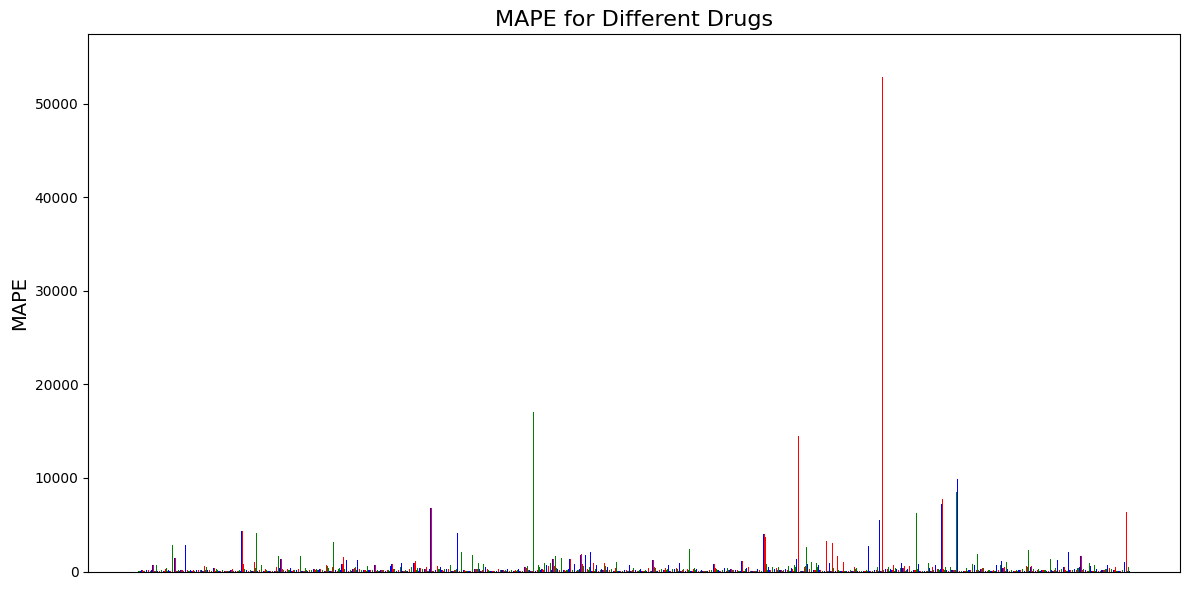

In [32]:
mape_values = [model_results['MAPE'] for drug, models in results.items() for model_name, model_results in models.items()]

# Create bar labels (i.e., 'AR', 'MA', 'ARIMA' for each drug)
bar_labels = [model for drug in results.keys() for model in results[drug]]

# Create histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(mape_values)), mape_values, color=['blue', 'green', 'red']*len(results))
plt.ylabel('MAPE', fontsize=14)
plt.title('MAPE for Different Drugs', fontsize=16)

# Label each bar with the corresponding model name
# for i, bar in enumerate(bars):
#     plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, bar_labels[i], ha='center', fontsize=9)

# Hide the x-axis ticks
plt.xticks([])

# Display histogram
plt.tight_layout()
plt.show()

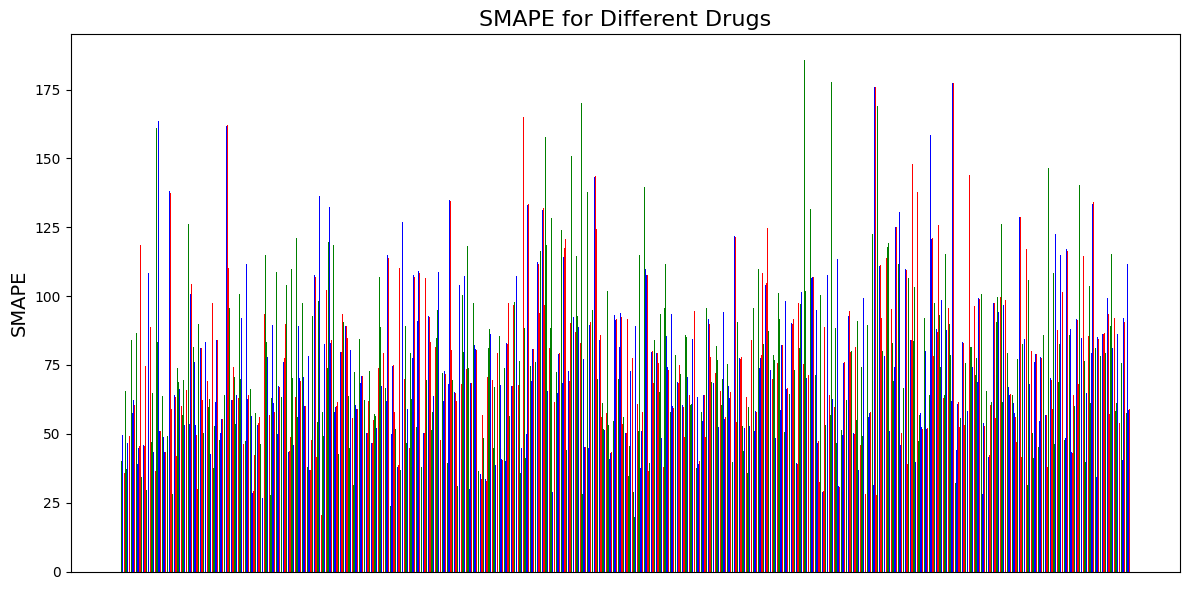

In [33]:
mape_values = [model_results['SMAPE'] for drug, models in results.items() for model_name, model_results in models.items()]

# Create bar labels (i.e., 'AR', 'MA', 'ARIMA' for each drug)
bar_labels = [model for drug in results.keys() for model in results[drug]]

# Create histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(mape_values)), mape_values, color=['blue', 'green', 'red']*len(results))
plt.ylabel('SMAPE', fontsize=14)
plt.title('SMAPE for Different Drugs', fontsize=16)

# Label each bar with the corresponding model name
# for i, bar in enumerate(bars):
#     plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, bar_labels[i], ha='center', fontsize=9)

# Hide the x-axis ticks
plt.xticks([])

# Display histogram
plt.tight_layout()
plt.show()